<a href="https://colab.research.google.com/github/MarioROT/CV-MAI/blob/main/Session%2010/lab_10_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #10 : Vision Transformers

At the end of this laboratory, you would get familiarized with

*   Vision Transformers

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Vision Transformers

Vision Transformers were introduced by Alexey Dosovitskiy et al. in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Read the ViT paper and answer the below descriptive questions.

*   What are the differences between CNN and Transformers?
*   What is Multi-head self-attention?
*   What is Inductive Bias?

**Solution**
- What are the differences between CNN and Transformers?
  - CNNs (Convolutional Neural Networks) are commonly used in computer vision tasks and have been the standard approach for image recognition. They rely on convolutional layers to extract local features from images and use pooling layers to downsample the feature maps.Transformers, on the other hand, have been widely used in natural language processing tasks but have limited applications in computer vision. They are based on self-attention mechanisms that allow them to capture global dependencies in the input sequence.

  - Unlike CNNs, which operate on local patches of an image, Transformers can directly process sequences of image patches without the need for convolutional layers. This makes them more flexible and efficient in terms of computational resources required for training.
  - CNNs have inherent inductive biases such as translation equivariance and locality, which make them effective in tasks with limited data. Transformers lack these biases and may not generalize well when trained on insufficient amounts of data.
  - While CNNs are well-suited for tasks with spatial information, Transformers are better at capturing long-range dependencies and global context, making them suitable for tasks that require understanding relationships between different parts of an image.

- What is Multi-head self-attention?
  - Multi-head self-attention is a mechanism used in Transformers that allows the model to attend to different parts of the input sequence simultaneously. It involves splitting the input into multiple smaller representations, called heads, and applying self-attention independently on each head.

  - Each head learns different relationships and captures different aspects of the input sequence, enabling the model to capture both local and global dependencies effectively.

  - The outputs of the multiple attention heads are then concatenated and linearly transformed to obtain the final representation. This allows the model to capture different types of information and improve its ability to understand complex patterns in the input.

- Inductive Bias
  - Inductive bias are assumptions or biases that a ML model includes during the learning process to make predictions based on limited training data.

  - CNNs have inherent inductive biases such as locality, two-dimensional neighborhood structure, and translation equivariance. These biases are baked into each layer of the CNN model, allowing it to effectively capture spatial information and patterns in images.

  - In contrast, Vision Transformers (ViTs) have much less image-specific inductive bias than CNNs. While ViTs use self-attention layers to capture global dependencies in the input sequence, they do not have the same level of built-in assumptions about spatial relationships. ViTs rely on the learning process to discover and understand spatial relations between image patches.

  - The reduced inductive bias in ViTs allows them to be more flexible and adaptable to different image recognition tasks, but it also means that they may require larger amounts of training data to generalize effectively.

...

*   Explain the model architecture of ViT.

**Solution**

The Vision Transformer (ViT) model architecture is based on the regulat Transformer architecture.
 1. ViT takes an image as input and divides it into a sequence of fixed-size non-overlapping patches.
 2. Each patch is linearly projected to a lower-dimensional representation, called the patch embedding, which serves as the input to the Transformer encoder.
 3. The Transformer encoder consists of multiple layers, each containing a multi-head self-attention mechanism and a feed-forward neural network. Layers included follow  Normalization --> Multi-Head Attention --> Normalization --> MLP.
 4. The self-attention mechanism allows the model to capture global dependencies between the patches, while the feed-forward network applies non-linear transformations to the patch embeddings.
 5. The outputs of the Transformer encoder are then passed through a classification head, which maps the sequence of patch embeddings to the final output classes.


...

# Introduction

We will implement the Vision Transformer (ViT) model for image classification and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.


## Setup
For this exercise, we require TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview)

In [ ]:
pip install -U tensorflow_addons

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Preparing the data

We will use the CIFAR-100 dataset available in tf.keras.datasets package.

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the Hyper-parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data Augmentation Pipeline

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement a Multi-layer Perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementing Patch Creation Layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualizing the patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


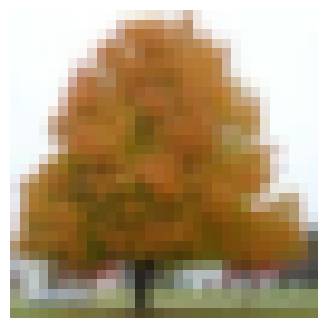

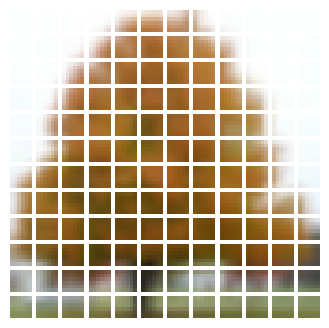

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Layer

*   What is the role of Patch Encoding Layer?

**Solution**
- Each patch is linearly projected to a lower-dimensional embeddin, the patch embeddings capture local information from the image patches and serve as the input to the Transformer encoder.The Transformer encoder then utilizes self-attention mechanisms to capture global dependencies between the patch embeddings, allowing the model to understand the relationships between different parts of the image.

...

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

*   What happens in the call function of the PatchEncoder class?

**Solution**

1. Projects the input patch using the dense layer.
2. Retrieves positional embeddings using the embedding layer based on the positions of the patches.
3. Adds the projected patch and positional embeddings element-wise.
4. Returns the encoded result

...

## Building the ViT Model

*   We will use the MultiHeadAttention layer as self-attention for this implementation
*   PS: There are many changes to the original paper for ease of execution

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

*   Explain the execution of the ViT model. What is the sequence of operations?
*   What is skip connection? Why is it needed?

**Solution**

* **Explain the execution of the ViT model. What is the sequence of operations?**
  - Input Processing:
    - The input image is received through the inputs layer.
    - Data augmentation is applied.
  - Patching:
    - The augmented image is divided into non-overlapping patches.
  - Patch Encoding:
    - Each patch is encoded using the PatchEncoder layer, by projecting it in a low-dimension representation and an embedding layer for positional information.
  - Transformer Blocks:
    - For each specified transformer block:
      - Layer normalization is applied to the encoded patches.
      - Multi-head self-attention processing is performed on the normalized patches.
      - The result of the attention operation is added to the original encoded patches using a skip connection.
      - Another layer normalization is applied to the output.
      - A MLP is applied to the output of the attention operation.
      - The output of the MLP is added to the output of the attention operation using another skip connection.
  - Global Feature Representation:
    - Layer normalization is applied to the final encoded patches.
    - The representation is flattened, and a dropout layer is added for regularization.
  - Final Classification Head:
    - An MLP is applied to the flattened representation.
    - The output of the MLP is used for classification through a dense layer.

- **What is skip connection? Why is it needed?**

  - It is a shortcut connection that bypasses one or more layers. The purpose of skip connections is to facilitate the flow of gradients during training, which helps in mitigating the vanishing gradient problem. They also allow the model to learn identity mappings, making it easier to learn more complex representations. The skip connections essentially provide a direct path for information to flow through the network, helping in the training of deeper models.

...

*   What is self-attention?
*   What is the problem in using global self-attention?
*   What can be used instead of global self-attention?

**Solution**

- **What is self-attention?**
  - It is a mechanism that allows a set of items in a sequence to focus on different parts of itself when processing information.

  - In NLP, self-attention is particularly useful for capturing relationships and dependencies between different words in a sentence. It enables the model to weigh the importance of each word in the context of the entire sequence, allowing for flexible and non-local information integration.

  - The self-attention mechanism operates on a set of input vectors (a.k.a. embeddings) and computes a set of output vectors, where each output vector is a weighted sum of the input vectors. The weights are determined dynamically based on the similarity or relevance between the elements in the input sequence. The attention scores are calculated using a compatibility function followed by a softmax operation to obtain normalized weights.
- **What is the problem in using global self-attention?**
  -
Global self-attention has computational challenges due to its quadratic time and space complexity with respect to the sequence length. The dot-product computation for attention scores results in $O(n^2)$ time complexity, making it computationally expensive for long sequences, and the quadratic space complexity of the attention matrix is memory-intensive. This limitation hinders the scalability of global self-attention for large datasets and real-world applications.

- **What can be used instead of global self-attention?**
  - To address global self-attention, variants like local attention, sparse attention, and approximate attention have been introduced, offering more efficient alternatives that maintain the benefits of self-attention while making it practical for processing long sequences.

...

## Training the ViT Model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

313/313 [==============================] - 7s 24ms/step - loss: 3.8696 - accuracy: 0.1164 - top-5-accuracy: 0.3281
Test accuracy: 11.64%
Test top 5 accuracy: 32.81%


### Creating history plots

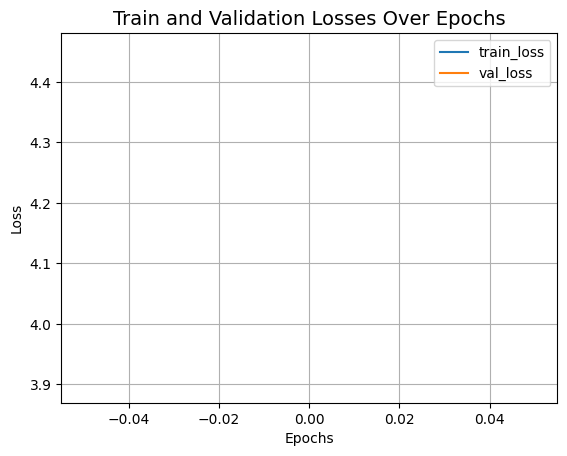

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Evaluating the trained ViT transformer

In [ ]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 7s 23ms/step - loss: 3.8696 - accuracy: 0.1164 - top-5-accuracy: 0.3281
Test loss: 3.87
Test accuracy: 11.64%
Test top 5 accuracy: 32.81%


# Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:
*   Start with an image.
*   Shift the image in diagonal directions.
*   Concat the diagonally shifted images with the original image.
*   Extract patches of the concatenated images.
*   Flatten the spatial dimension of all patches.
*   Layer normalize the flattened patches and then project it.

More details about the implementation can be read from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1)

---
*   Implement a shiftedpatchtokenizer class
*   The class should implement the __init__() and call() functions
*   Implement left-up, right-up, left-down and right-down shift operations


In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=image_size,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=num_patches, projection_dim=projection_dim, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

- Visualize the patches for a random image

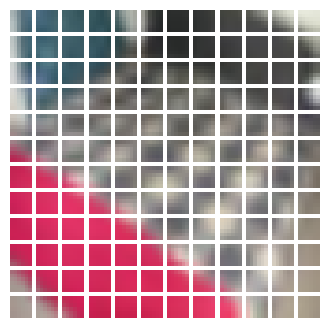

ORIGINAL


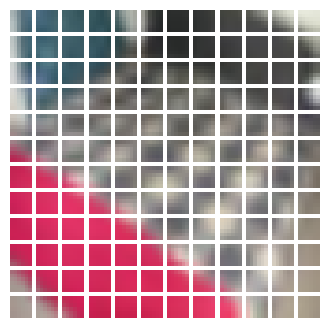

LEFT-UP


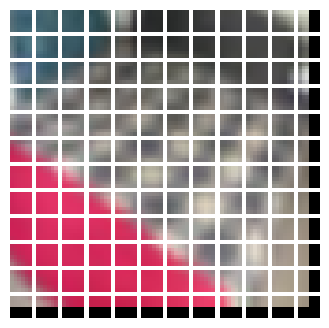

LEFT-DOWN


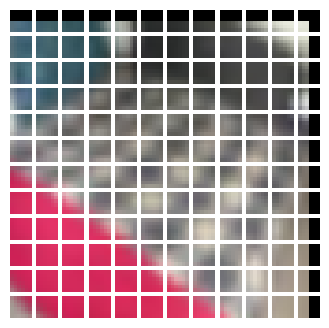

RIGHT-UP


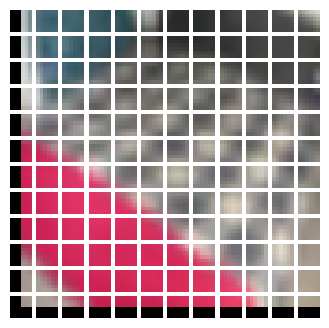

RIGHT-DOWN


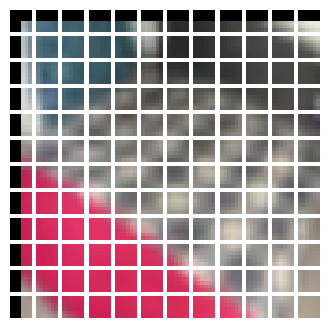

In [ ]:
#solution
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (patch_size, patch_size, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

- Compile and train the classifier

In [ ]:
def create_vit_classifier_SLP():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=False)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# solution
vit_classifier_SLP = create_vit_classifier_SLP()
history_SLP = run_experiment(vit_classifier_SLP)

313/313 [==============================] - 9s 27ms/step - loss: 3.9747 - accuracy: 0.1016 - top-5-accuracy: 0.3051
Test accuracy: 10.16%
Test top 5 accuracy: 30.51%


- Create the history plot for the new ViT model
- Evaluate the model using the test set

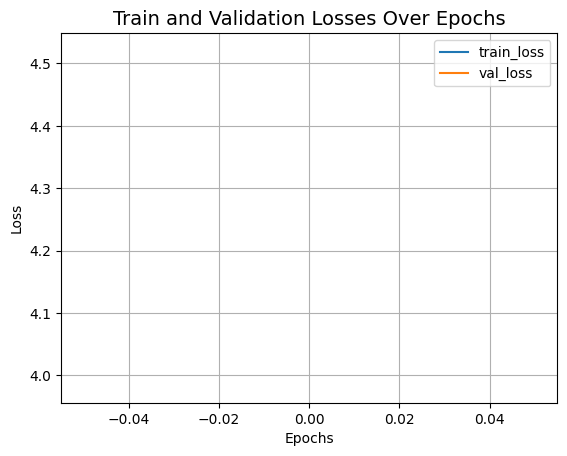

313/313 [==============================] - 9s 30ms/step - loss: 3.9747 - accuracy: 0.1016 - top-5-accuracy: 0.3051
Test loss: 3.97
Test accuracy: 10.16%
Test top 5 accuracy: 30.51%


In [ ]:
# solution
plt.plot(history_SLP.history["loss"], label="train_loss")
plt.plot(history_SLP.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

loss, accuracy, top_5_accuracy = vit_classifier_SLP.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

- Compute confusion matrix and classification summary of both the models
- Compare both the models with respect to the computed metrics

------ Normal VIT
313/313 [==============================] - 8s 21ms/step


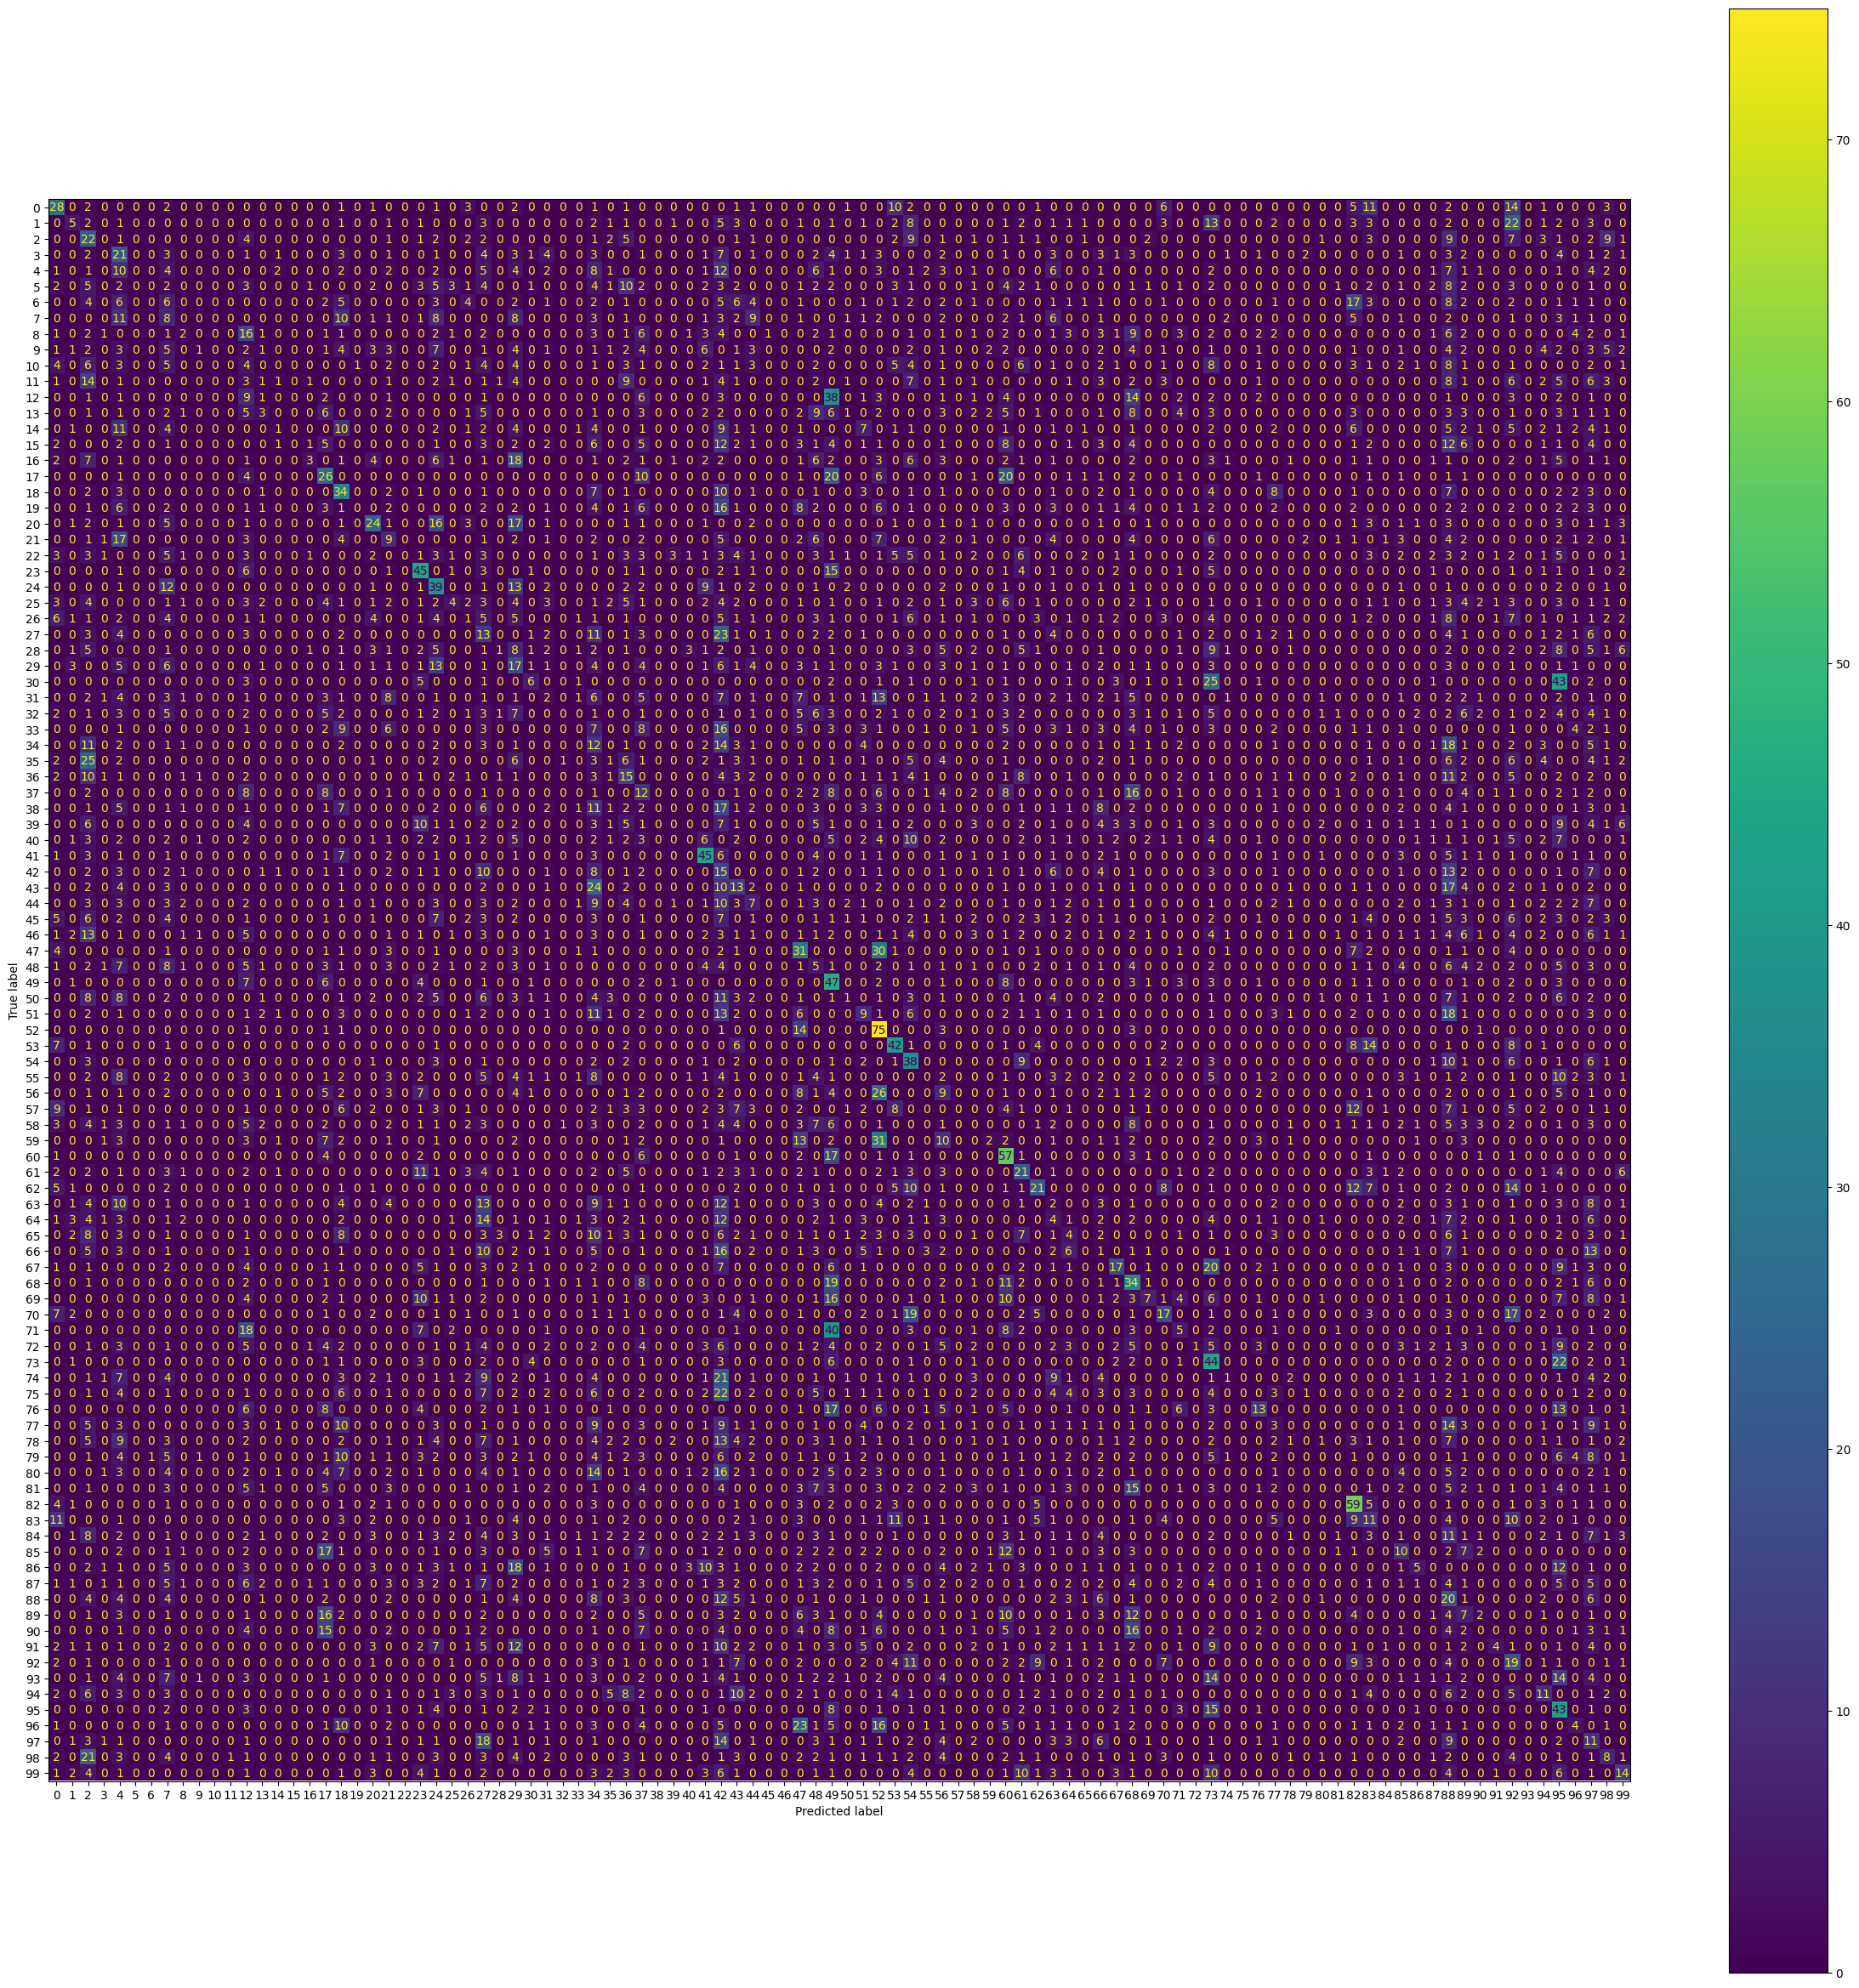

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.21      0.28      0.24       100\n           1       0.15      0.05      0.07       100\n           2       0.07      0.22      0.11       100\n           3       0.00      0.00      0.00       100\n           4       0.04      0.10      0.06       100\n           5       0.00      0.00      0.00       100\n           6       0.00      0.00      0.00       100\n           7       0.04      0.08      0.05       100\n           8       0.10      0.02      0.03       100\n           9       0.17      0.01      0.02       100\n          10       0.00      0.00      0.00       100\n          11       0.00      0.00      0.00       100\n          12       0.04      0.09      0.06       100\n          13       0.12      0.03      0.05       100\n          14       0.08      0.01      0.02       100\n          15       0.00      0.00      0.00       100\n          16       0.30      0.03      0.05       100\n       

In [ ]:
# solution
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print('------ Normal VIT')
y_pred = vit_classifier.predict(x_test).argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test.T[0]))
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
classification_report(y_test.T[0], y_pred, target_names=list(map(str,np.unique(y_test.T[0]))))

------ Normal VIT
313/313 [==============================] - 11s 25ms/step


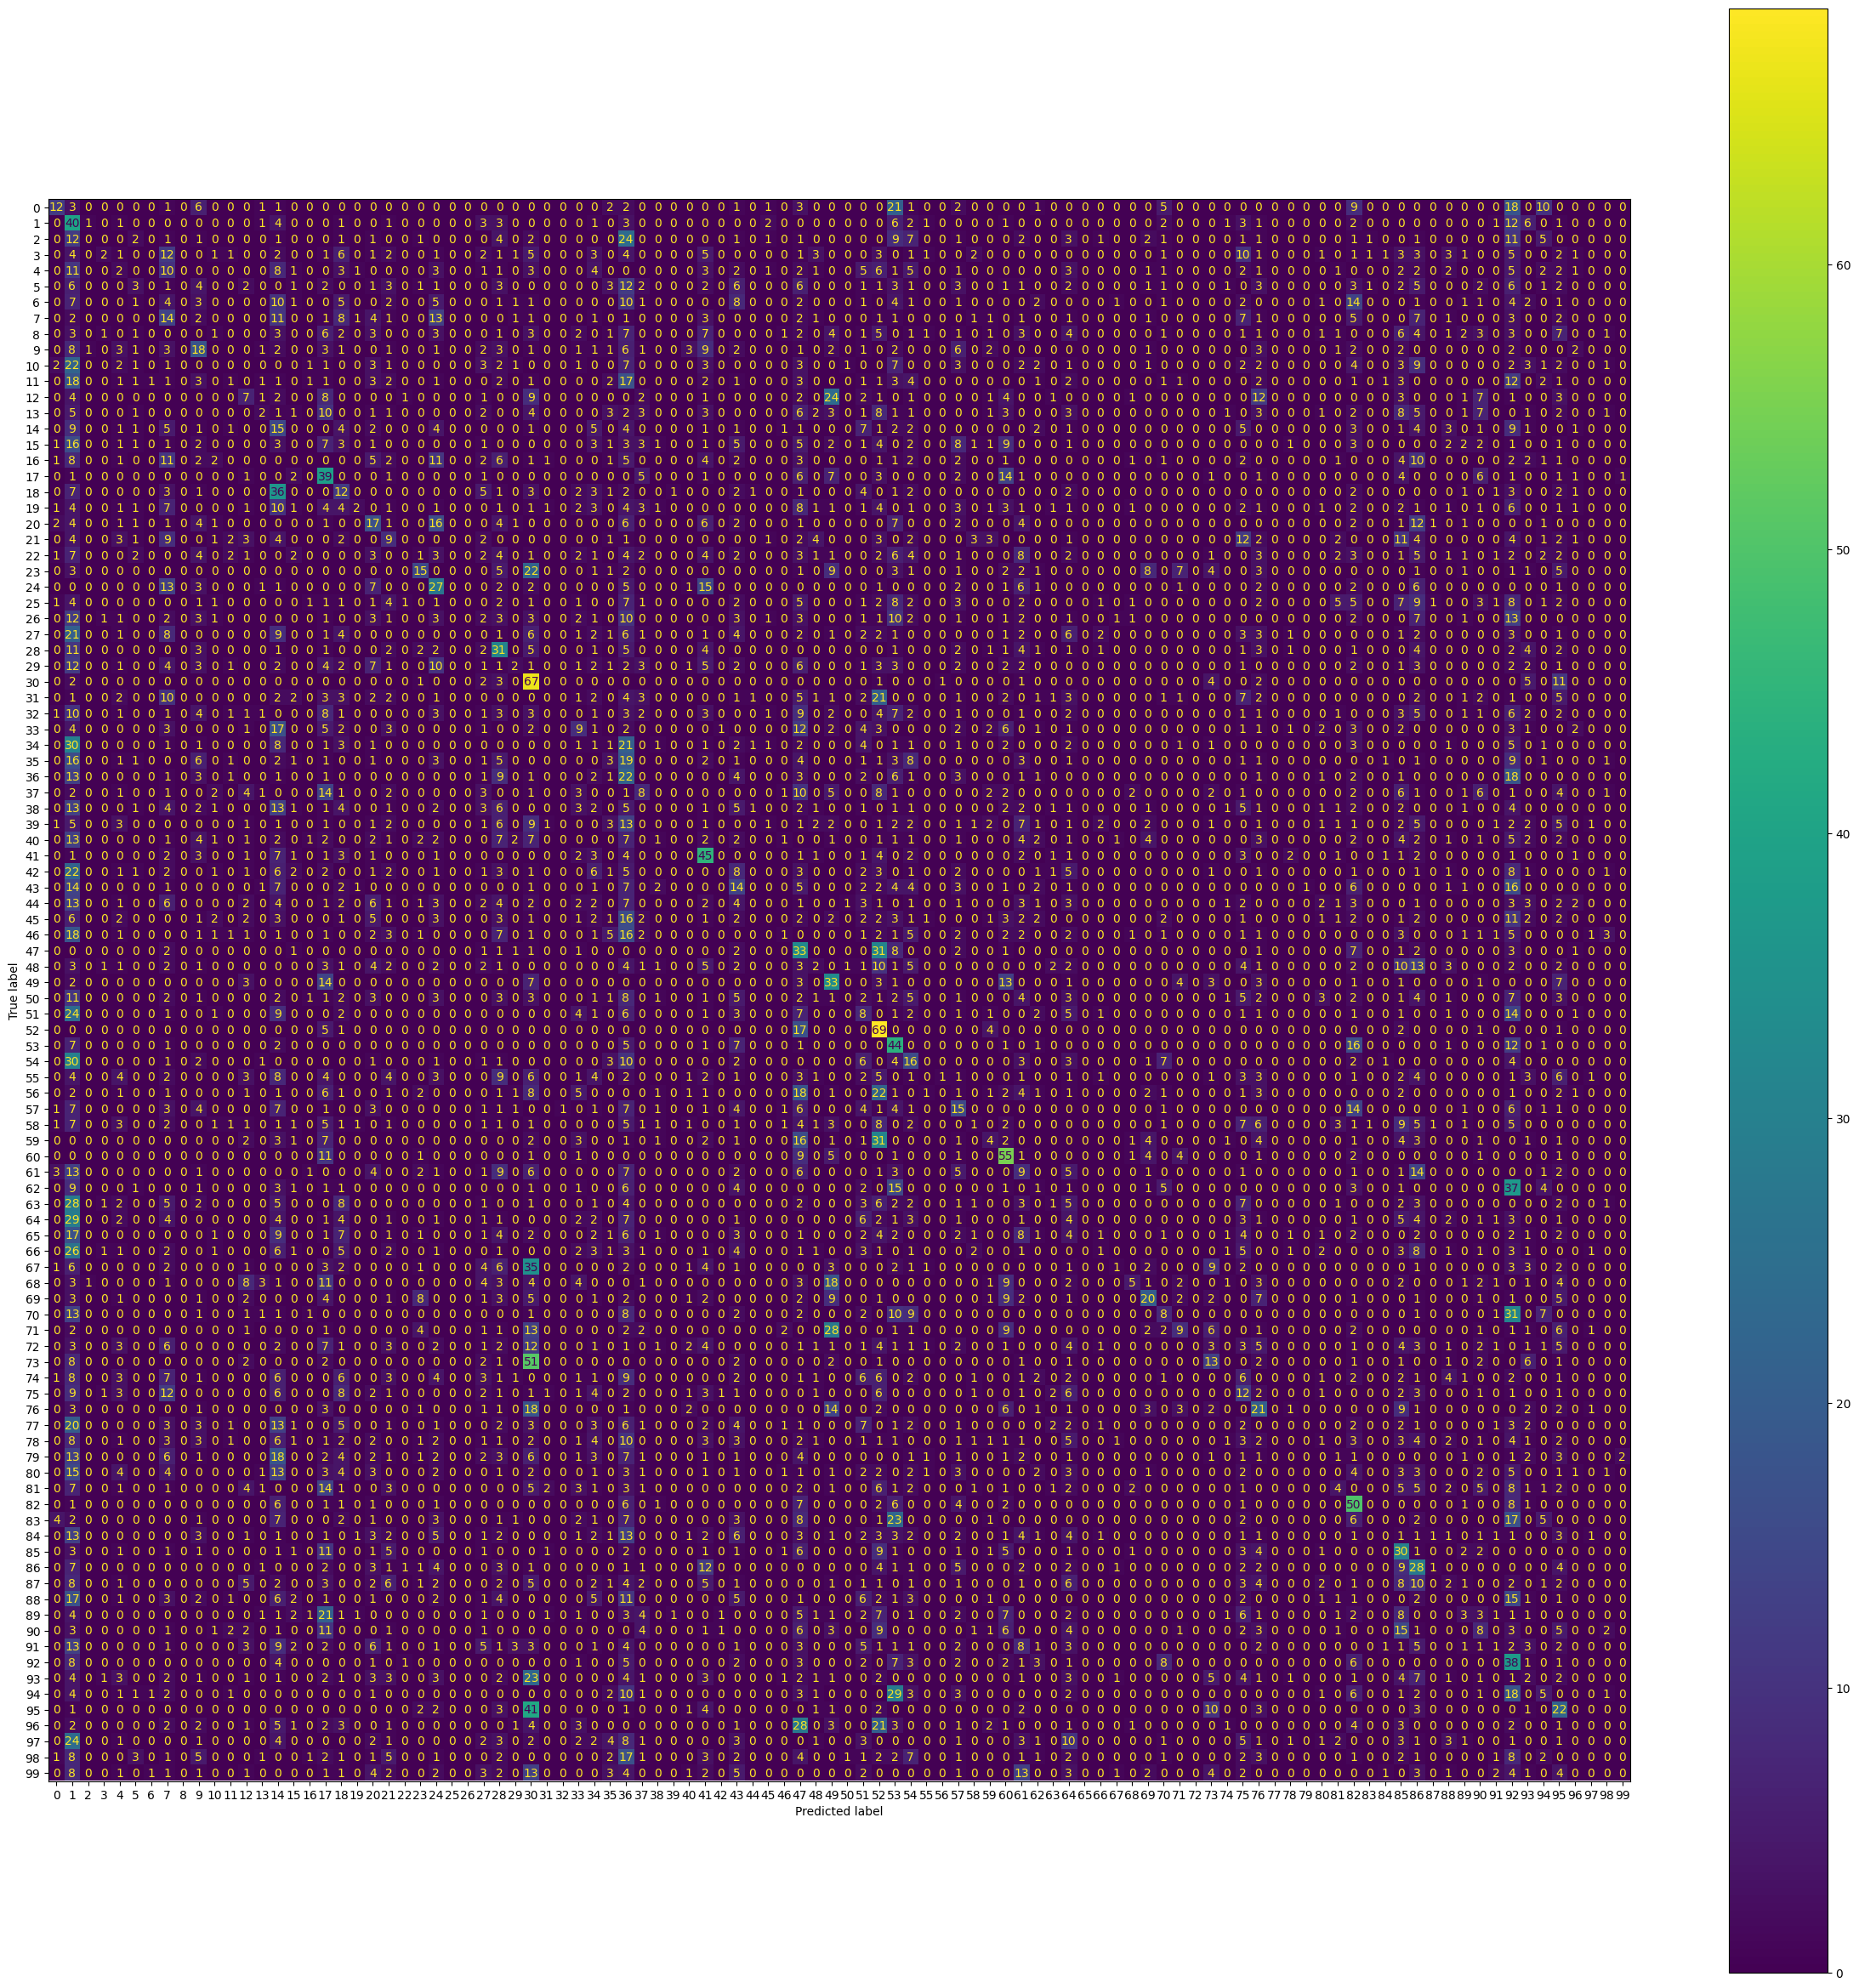

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.34      0.12      0.18       100\n           1       0.04      0.40      0.08       100\n           2       0.00      0.00      0.00       100\n           3       0.22      0.02      0.04       100\n           4       0.03      0.02      0.02       100\n           5       0.12      0.03      0.05       100\n           6       0.00      0.00      0.00       100\n           7       0.06      0.14      0.08       100\n           8       0.00      0.00      0.00       100\n           9       0.14      0.18      0.16       100\n          10       0.00      0.00      0.00       100\n          11       0.05      0.01      0.02       100\n          12       0.10      0.07      0.08       100\n          13       0.10      0.02      0.03       100\n          14       0.04      0.15      0.06       100\n          15       0.00      0.00      0.00       100\n          16       0.00      0.00      0.00       100\n       

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print('------ Shifted Patch Tokenization +  VIT')
y_pred = vit_classifier_SLP.predict(x_test).argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test.T[0]))
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
classification_report(y_test.T[0], y_pred, target_names=list(map(str,np.unique(y_test.T[0]))))

**Solution**

*(Double-click or enter to edit)*

...

*   Compare DeiT with ViT.
*   What are the differences in both the architectures.
*   What is one limitation of ViT that is overcome with a DeiT?

**Solution**

**What are the differences in both the architectures.**

DeiT (Data-efficient image Transformer) and ViT (Vision Transformer) are both transformer-based architectures for computer vision, but their key difference lies in training. ViT processes images using fixed-size patches, while DeiT prioritizes data efficiency by leveraging a pre-trained convolutional neural network (CNN) for feature extraction, training only the transformer part on limited labeled data. This makes DeiT competitive with ViT while requiring less labeled data.

**What is one limitation of ViT that is overcome with a DeiT?**
One limitation of ViT is its reliance on a large labeled dataset for effective training. DeiT overcomes this by employing knowledge distillation, using a pre-trained CNN to efficiently transfer knowledge to the transformer architecture. This makes DeiT more data-efficient, addressing the limitation of data scarcity associated with ViT.

**What is a SWIN Transformer?**
How is it different from DeiT and ViT?
Is a transformer architecture that emphasizes a shifted window mechanism. Unlike traditional transformers, SWIN uses a hierarchical structure with shifting windows to efficiently capture global information at different scales. This design enhances its performance in tasks such as image classification.

...

*   What is a SWIN Transformer?
*   How is it different from DeiT and ViT?

**Solution**

What is a SWIN Transformer?
How is it different from DeiT and ViT?
Is a transformer architecture that emphasizes a shifted window mechanism. Unlike traditional transformers, SWIN uses a hierarchical structure with shifting windows to efficiently capture global information at different scales. This design enhances its performance in tasks such as image classification.

...

*   What is distillation?
*   Explain the distillation used in DeiT
*   What is its significance? Why do we need distillation?

**Solution**

Distillation is a process where knowledge from a larger model is transferred to a smaller one. The goal is to make the smaller model more efficient by reproducing the predictions or internal representations of the larger model. This technique is used to balance model size and performance.

In DeiT distillation involves transferring knowledge from a pre-trained convolutional neural network (CNN) to the transformer architecture. The process begins by training a large CNN on a vast dataset for feature extraction. Then it is distilled into the smaller transformer model, enabling it to benefit from the insights gained by the larger CNN. Basically, we use distillation to enhance its performance by efficiently transferring knowledge from a larger, pre-trained model to a more compact transformer architecture.

...


---

## **End of lab10: Vision Transformers**